# Building a Neural Network from scratch


## Context
A neural network (NN) is composed of layers. An $\textit{input layer}$ where a single or vector of inputs can be fed into the NN, and an $\textit{output layer}$, again the output could be singular (scalar) or contain a vector of outputs, and in the middle, $\textit{hidden layers}$. These hidden layers are where the magic happens. Shallow NNs have one hidden layer with multiple $\textit{nodes}$ whearas deep NNs contain multiple hidden layers.  

## The magic
As we said above, the hidden layers are filled with nodes. Each node has a $\textit{weight}$ that comes with it which is updated with each pass back through the network (backpropagation). Each hidden layer also comes with a $\textit{bias}$ that gets added to the weights at each layer. We train the NN by feeding through some training $x$ data, then use the NN, initialised with random weights, to predict an output $y$, whereupon a loss function will determine how "correct" the weights are. We then use the optimizer to perform backpropagation through the network to update the weights according to the loss function, whereupon we then feed through more $x$ data. We repeat the process until the loss function is below a certain tolerance.

## Risks 
#### Overfitting
Training the network by letting it go through the training data over and over again (epochs) is a good way to fit your training data well, but the network will likely not be $\textit{generalisable}$ to your test data. This is why we have $\textit{regularisation}$, where larger values for the loss function are punished to avoid the weights changing drastically. There are other ways to regularise NNs as well.

#### Vanishing gradients
This was an early problem in training deep neural networks, where each pass of backpropagation causes the gradients to become smaller and smaller, until the weights stop updating all together. To fix this, we introduce the $\textit{ReLU}$ function, where the outputs of a layer are clamped to never go below 0, solving the vanishing gradients problem. 

<img src="figure/NN.png" alt="NN" width="500px" style="display:flex;align-items:center;">

Figure 1: Typical NN with an input layer, three hidden layers, and an output layer.

## This project
In this project, we build a neural network from scratch, only using numpy to compute mathematical oporations such as ```np.dot(x,y)```. We will then train this neural network on the MNIST numbers dataset and evaluate its performance. If it does well, we can also evaluate it on the fashion MNIST dataset. 

In [363]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## Import Data

In [388]:
mnist_test = pd.read_csv('MNIST_CSV/mnist_test.csv')
mnist_train = pd.read_csv('MNIST_CSV/mnist_train.csv')
mnist_test = np.array(mnist_test)
mnist_train = np.array(mnist_train)

## Test plot for a number

(-0.5, 27.5, 27.5, -0.5)

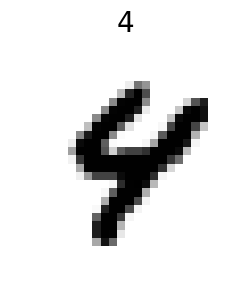

In [398]:

fig, ax = plt.subplots(figsize=(3, 3))
randint = np.random.randint(0, mnist_train.shape[0])
ax.imshow(np.reshape(mnist_train[randint, 1:], (28, 28)), cmap='Greys')
ax.set_title(f"{mnist_train[randint, 0]}", fontsize=20)
ax.axis('off')

### Change single label into array of 0s and 1s, (one hot)

In [401]:
def one_hot(label):
    Y = np.zeros(10)
    Y[label] = 1
    return Y

## Coding one Neuron

In [4]:
class Neuron:
    def __init__(self, weight, biases, input):
        self.weight = weight
        self.biases = biases
        self.input = input
        self.output = 0 
    
    def forward(self) -> float:
        self.output = np.dot(self.input, self.weight) + self.biases
        return self.output

In [6]:
w = np.random.uniform(0, 5, 5)
b = np.random.uniform(0, 5, 5)
X_data = np.random.uniform(0, 100, 5)

neuron = Neuron(weight=w, biases=b, input=X_data)
output = neuron.forward()

print(output)

[331.83507077 328.30188178 328.44918341 329.69167679 331.31690374]


## Whole Network of hidden layers and neurons

In [7]:
def normalise(weights: np.ndarray)-> np.ndarray:
    w_max = np.max(weights)
    w_min = np.min(weights)
    return (weights - w_min) / (w_max - w_min)

In [451]:
def Linear(x, weights, bias):
        """Linear hidden layer"""
        weights = normalise(weights)
        return np.dot(x, weights) + bias

def ReLU(inputs) -> np.ndarray:
    """Activation function"""
    return np.maximum(0, inputs)

def softMax(inputs: np.ndarray) -> np.ndarray:
    exps = np.exp(inputs - inputs.max())
    return exps / np.sum(exps)

def initialise_weights(num_HL, HL_structure, num_inputs, num_outputs) -> (np.ndarray, np.ndarray):
    params = {"W_inputs": np.random.uniform(0, 1, size=(num_inputs, HL_structure[0]))}
    for i in range(num_HL-1):
        if i == num_HL-1:
            params[f"W{i+1}"] = np.random.uniform(0, 1, size=(HL_structure[i], num_outputs))
        else:
            params[f"W{i+1}"] = np.random.uniform(0, 1, size=(HL_structure[i], HL_structure[i+1]))
    params["W_outputs"] = np.random.uniform(0, 1, size=(HL_structure[-1], num_outputs))
    biases = np.zeros(num_HL+2) # +2 for input and output
    biases[1:-1] = np.random.uniform(0, 1, num_HL) # Avoiding ends because inputs and outputs don't have biases
    return params, biases


class NeuralNetwork:
    def __init__(self, num_inputs, hidden_layer_structure, num_outputs):
        
        self.num_inputs = num_inputs
        self.num_hidden_layers = len(hidden_layer_structure)
        self.hidden_layer_structure = hidden_layer_structure
        self.num_outputs = num_outputs
        
        # Randomly initialise weights and biases
        self.weights, self.biases = initialise_weights(num_HL=self.num_hidden_layers,
                                              HL_structure=self.hidden_layer_structure,
                                              num_inputs=self.num_inputs,
                                              num_outputs=self.num_outputs)
        # Information I may want
        self.num_nodes = self.num_hidden_layers + sum(hidden_layer_structure)
    
    def forward(self, x):
        Zs, As = {}, {}
        for i, weight_matrix in enumerate(self.weights.values()):
            if i == 0:
                Zs[f"Z{i+1}"] = Linear(x, weight_matrix, self.biases[i])
                As[f"A{i+1}"] = ReLU(Zs[f"Z{i+1}"])
            else:
                Zs[f"Z{i+1}"] = Linear(Zs[f"Z{i}"], weight_matrix, self.biases[i])
                As[f"A{i+1}"] = ReLU(Zs[f"Z{i+1}"])
    
        output = softMax(Zs[f"Z{i+1}"])
        return output, Zs, As

In [452]:
def cross_entropy(outputs, targets):
    """Classification Loss Function"""
    return - np.sum(softMax(targets) * np.log(outputs))

def deriv_ReLU(x):
    return x > 0

In [453]:
class Loss:
    def __init__(self, loss_function, params):
        self.loss_function = loss_function
        self.params = params
    
    def loss_func(self, outputs, targets):
        return self.loss_function(outputs, targets)
    
    def backward(self):
        for key, value in self.params.items():
            print(key, value.shape)

In [457]:
rand_num = mnist_train[randint, 1:]
true_label = one_hot(mnist_train[randint, 0])

NN = NeuralNetwork(num_inputs=len(rand_num),
                   hidden_layer_structure=[128, 64, 32],
                   num_outputs=len(true_label))

loss = Loss(loss_function=cross_entropy, 
            params=NN.weights)

outputs, Zs, As= NN.forward(X_data)
print(outputs)
print(true_label)
# for key, value in Zs.items():
#     print(key, value.shape)
# loss.loss_func(outputs, true_label)

[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
